In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from functools import partial

In [66]:
def Data(num, seed=42):
    random.seed(seed * num)
    return [[random.random() for dimension in range(2)] for point in range(num)] 

def FileData(filename):
    with open(filename, "r") as f:
        return [line.strip().split() for line in f.readlines()]

getindex = lambda x, i: x[i]
X = partial(getindex, i=0)
Y = partial(getindex, i=1)

In [67]:
def plot(dataset):
    plt.scatter(map(X, dataset), map(Y, dataset), s=3)
    plt.axis('off')

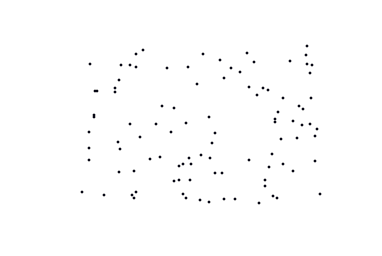

In [68]:
plot(Data(100))

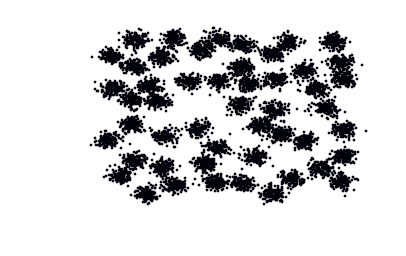

In [69]:
plot(FileData("data.txt"))